In [1]:
import sys
sys.path.insert(0, "../")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from src.dataloader import *
from triage.triage import Triage
from src.utils import *


In [3]:
df, _, _ = load_seer_cutract_dataset(name="seer", seed=42)

cols = df.columns


# Helper to compute evaluation time as part of the overall

In [4]:
def evaluate_methods(X_prop_train, y_prop_train, X_cal, y_cal, X_test, y_test, seed):
    from sklearn.metrics import mean_absolute_error as reg_metric
    from sklearn.metrics import mean_squared_error as reg_metric_mse
    results = {}
    results_mse = {}

    ######
    myids = we_ids
    len(myids)

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["TRIAGE"] = reg_metric(y_test, y_pred)
    results_mse["TRIAGE"] = reg_metric_mse(y_test, y_pred)

    return results, results_mse


# Helper to modify n_samples for compute time exp

In [5]:
def load_seer_cutract_dataset(name="seer", seed=42, n=1000):
    """Function that loads the Seer and Cutract dataset."""

    # third party
    import pandas as pd
    import sklearn

    def aggregate_grade(row):
        if row["grade_1.0"] == 1:
            return 1
        if row["grade_2.0"] == 1:
            return 2
        if row["grade_3.0"] == 1:
            return 3
        if row["grade_4.0"] == 1:
            return 4
        if row["grade_5.0"] == 1:
            return 5

    def aggregate_stage(row):
        if row["stage_1"] == 1:
            return 1
        if row["stage_2"] == 1:
            return 2
        if row["stage_3"] == 1:
            return 3
        if row["stage_4"] == 1:
            return 4
        if row["stage_5"] == 1:
            return 5

    # Features to keep
    features = [
        "age",
        "mortCancer",
        "comorbidities",
        "treatment_CM",
        "treatment_Primary hormone therapy",
        "treatment_Radical Therapy-RDx",
        "treatment_Radical therapy-Sx",
        "grade",
        "stage_1",
        "stage_2",
        "stage_3",
        "stage_4",
    ]

    label = "psa"
    df = pd.read_csv(f"../data/{name}.csv")

    df["grade"] = df.apply(aggregate_grade, axis=1)
    df["stage"] = df.apply(aggregate_stage, axis=1)
    df["mortCancer"] = df["mortCancer"].astype(int)
    df["mort"] = df["mort"].astype(int)

    mask = df["mortCancer"] == True  # noqa: E712
    df_dead = df[mask]
    df_survive = df[~mask]

    if name == "seer":
        n_samples = n
        ns = n
    else:
        n_samples = 1000
        ns = 1000
    df = pd.concat(
        [
            df_dead.sample(ns, random_state=seed, replace=True),
            df_survive.sample(n_samples, random_state=seed),
        ],
    )

    df = sklearn.utils.shuffle(df, random_state=seed)
    df = df.reset_index(drop=True)
    return df[features], df[label], df


# Assess compute time

In [6]:
import random
import time
from copy import deepcopy
import xgboost as xgb
from tqdm import tqdm

full_results = {}
full_results_mse = {}

run_triage = {}
run_total = {}
run_train = {}

cal_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nlist = [1000, 5000, 10000, 25000, 50000, 75000, 100000]
n_runs = 1


for calsize in cal_list:
    full_triage_time = {}
    full_train_time = {}
    full_total_time = {}
    for nsamps in tqdm(nlist):
        print("--------------------------------")
        print(f"Running cal size = {calsize}")
        print("--------------------------------")
        triage_time = []
        train_time = []
        total_time = []
        for i in range(n_runs):

            seed = i * 10
            random.seed(seed)

            X_prop_train, y_prop_train, _ = load_seer_cutract_dataset(
                name="seer", seed=seed, n=nsamps
            )

            min_y = y_prop_train.min()
            max_y = y_prop_train.max()

            y_prop_train = np.array(
                [
                    (y_prop_train[i] - min_y) / (max_y - min_y)
                    for i in range(len(y_prop_train))
                ]
            )
            y_prop_train = pd.Series(y_prop_train)

            X_eval, y_eval, _ = load_seer_cutract_dataset(name="cutract", seed=seed)

            y_eval = np.array(
                [(y_eval[i] - min_y) / (max_y - min_y) for i in range(len(y_eval))]
            )
            y_eval = pd.Series(y_eval)

            test_ids = random.sample(list(range(len(y_eval))), int(0.5 * len(y_eval)))

            X_test, y_test = X_eval.iloc[test_ids, :], y_eval.iloc[test_ids]

            remaining_eval_ids = np.setdiff1d(range(len(y_eval)), test_ids)

            _, X_cal, _, y_cal = train_test_split(
                X_eval.iloc[remaining_eval_ids, :],
                y_eval.iloc[remaining_eval_ids],
                test_size=calsize,
                random_state=seed,
            )

            X_prop_train, X_cal, X_test = (
                np.array(X_prop_train),
                np.array(X_cal),
                np.array(X_test),
            )
            y_prop_train, y_cal, y_test = (
                np.array(y_prop_train),
                np.array(y_cal),
                np.array(y_test),
            )

            prop = 0.1
            num_ids = int(prop * len(y_prop_train))
            last_ids = range(len(y_prop_train))
            y_prop_train_corrupt = deepcopy(y_prop_train)
            corruptids = random.sample(list(last_ids), num_ids)
            for myid in corruptids:
                corruption = (np.random.choice(5, 1)[0] / 2) + 1
                y_prop_train_corrupt[myid] = y_prop_train_corrupt[myid] * corruption

            start = time.time()

            nest = 10
            learner = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
            learner.fit(X_prop_train, y_prop_train)

            end = time.time()
            train_t = end - start

            y_eval = y_prop_train
            X_eval = X_prop_train

            triage = Triage(
                X_eval=X_eval,
                y_eval=y_eval,
                X_cal=X_cal,
                y_cal=y_cal,
                nest=nest,
                learner=learner,
            )
            groups_ids, raw_metrics = triage.run()

            triage_array = raw_metrics["score_metric"]

            percentile_thresh = 75
            thresh = 0.33
            conf_thresh_low = thresh
            conf_thresh_high = 1 - thresh
            conf_thresh = 0.5

            variability = np.std(triage_array, axis=-1)  
            confidence = np.mean(triage_array, axis=-1)

            uncert_percentile = np.percentile(variability, percentile_thresh)

            oe_ids = np.where(
                (confidence <= conf_thresh_low)
                & (variability <= np.percentile(variability, percentile_thresh))
            )[0]
            ue_ids = np.where(
                (confidence >= conf_thresh_high)
                & (variability <= np.percentile(variability, percentile_thresh))
            )[0]

            other_ids = np.concatenate((oe_ids, ue_ids))
            we_ids = []
            for id in range(len(confidence)):
                if id not in other_ids:
                    we_ids.append(id)

            we_ids = np.array(we_ids)

            end = time.time()
            duration_triage = end - start

            n_keep = len(we_ids)
            end = time.time()
            triage_t = end - start

            total_t = triage_t + train_t

            triage_time.append(triage_t)
            total_time.append(total_t)
            train_time.append(train_t)

        full_triage_time[nsamps] = triage_time
        full_train_time[nsamps] = train_time
        full_total_time[nsamps] = total_time

    run_triage[calsize] = full_triage_time
    run_train[calsize] = full_train_time
    run_total[calsize] = full_total_time


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.01
--------------------------------


 14%|█▍        | 1/7 [00:03<00:18,  3.09s/it]

--------------------------------
Running cal size = 0.01
--------------------------------


 29%|██▊       | 2/7 [00:07<00:17,  3.57s/it]

--------------------------------
Running cal size = 0.01
--------------------------------


 43%|████▎     | 3/7 [00:12<00:17,  4.29s/it]

--------------------------------
Running cal size = 0.01
--------------------------------


 57%|█████▋    | 4/7 [00:21<00:18,  6.24s/it]

--------------------------------
Running cal size = 0.01
--------------------------------


 71%|███████▏  | 5/7 [00:38<00:20, 10.25s/it]

--------------------------------
Running cal size = 0.01
--------------------------------


 86%|████████▌ | 6/7 [01:05<00:15, 15.91s/it]

--------------------------------
Running cal size = 0.01
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.05
--------------------------------


 14%|█▍        | 1/7 [00:03<00:18,  3.16s/it]

--------------------------------
Running cal size = 0.05
--------------------------------


 29%|██▊       | 2/7 [00:07<00:18,  3.66s/it]

--------------------------------
Running cal size = 0.05
--------------------------------


 43%|████▎     | 3/7 [00:12<00:17,  4.37s/it]

--------------------------------
Running cal size = 0.05
--------------------------------


 57%|█████▋    | 4/7 [00:22<00:20,  6.69s/it]

--------------------------------
Running cal size = 0.05
--------------------------------


 71%|███████▏  | 5/7 [00:41<00:22, 11.19s/it]

--------------------------------
Running cal size = 0.05
--------------------------------


 86%|████████▌ | 6/7 [01:12<00:17, 17.98s/it]

--------------------------------
Running cal size = 0.05
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.1
--------------------------------


 14%|█▍        | 1/7 [00:02<00:17,  2.95s/it]

--------------------------------
Running cal size = 0.1
--------------------------------


 29%|██▊       | 2/7 [00:06<00:17,  3.53s/it]

--------------------------------
Running cal size = 0.1
--------------------------------


 43%|████▎     | 3/7 [00:12<00:17,  4.38s/it]

--------------------------------
Running cal size = 0.1
--------------------------------


 57%|█████▋    | 4/7 [00:23<00:20,  6.88s/it]

--------------------------------
Running cal size = 0.1
--------------------------------


 71%|███████▏  | 5/7 [00:46<00:25, 12.70s/it]

--------------------------------
Running cal size = 0.1
--------------------------------


 86%|████████▌ | 6/7 [01:22<00:20, 20.76s/it]

--------------------------------
Running cal size = 0.1
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.2
--------------------------------


 14%|█▍        | 1/7 [00:03<00:18,  3.14s/it]

--------------------------------
Running cal size = 0.2
--------------------------------


 29%|██▊       | 2/7 [00:07<00:19,  3.86s/it]

--------------------------------
Running cal size = 0.2
--------------------------------


 43%|████▎     | 3/7 [00:13<00:19,  4.86s/it]

--------------------------------
Running cal size = 0.2
--------------------------------


 57%|█████▋    | 4/7 [00:25<00:22,  7.58s/it]

--------------------------------
Running cal size = 0.2
--------------------------------


 71%|███████▏  | 5/7 [00:46<00:25, 12.64s/it]

--------------------------------
Running cal size = 0.2
--------------------------------


 86%|████████▌ | 6/7 [01:21<00:20, 20.25s/it]

--------------------------------
Running cal size = 0.2
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.3
--------------------------------


 14%|█▍        | 1/7 [00:02<00:17,  2.90s/it]

--------------------------------
Running cal size = 0.3
--------------------------------


 29%|██▊       | 2/7 [00:07<00:18,  3.68s/it]

--------------------------------
Running cal size = 0.3
--------------------------------


 43%|████▎     | 3/7 [00:13<00:18,  4.73s/it]

--------------------------------
Running cal size = 0.3
--------------------------------


 57%|█████▋    | 4/7 [00:24<00:22,  7.52s/it]

--------------------------------
Running cal size = 0.3
--------------------------------


 71%|███████▏  | 5/7 [00:47<00:26, 13.11s/it]

--------------------------------
Running cal size = 0.3
--------------------------------


 86%|████████▌ | 6/7 [01:23<00:20, 20.79s/it]

--------------------------------
Running cal size = 0.3
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.4
--------------------------------


 14%|█▍        | 1/7 [00:03<00:18,  3.11s/it]

--------------------------------
Running cal size = 0.4
--------------------------------


 29%|██▊       | 2/7 [00:07<00:19,  3.81s/it]

--------------------------------
Running cal size = 0.4
--------------------------------


 43%|████▎     | 3/7 [00:14<00:20,  5.21s/it]

--------------------------------
Running cal size = 0.4
--------------------------------


 57%|█████▋    | 4/7 [00:27<00:25,  8.45s/it]

--------------------------------
Running cal size = 0.4
--------------------------------


 71%|███████▏  | 5/7 [01:00<00:34, 17.17s/it]

--------------------------------
Running cal size = 0.4
--------------------------------


 86%|████████▌ | 6/7 [02:41<00:45, 45.64s/it]

--------------------------------
Running cal size = 0.4
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.5
--------------------------------


 14%|█▍        | 1/7 [00:06<00:38,  6.46s/it]

--------------------------------
Running cal size = 0.5
--------------------------------


 29%|██▊       | 2/7 [00:17<00:44,  8.97s/it]

--------------------------------
Running cal size = 0.5
--------------------------------


 43%|████▎     | 3/7 [00:32<00:47, 11.91s/it]

--------------------------------
Running cal size = 0.5
--------------------------------


 57%|█████▋    | 4/7 [00:57<00:50, 16.96s/it]

--------------------------------
Running cal size = 0.5
--------------------------------


 71%|███████▏  | 5/7 [01:34<00:48, 24.26s/it]

--------------------------------
Running cal size = 0.5
--------------------------------


 86%|████████▌ | 6/7 [02:38<00:37, 37.81s/it]

--------------------------------
Running cal size = 0.5
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.6
--------------------------------


 14%|█▍        | 1/7 [00:07<00:46,  7.73s/it]

--------------------------------
Running cal size = 0.6
--------------------------------


 29%|██▊       | 2/7 [00:18<00:47,  9.59s/it]

--------------------------------
Running cal size = 0.6
--------------------------------


 43%|████▎     | 3/7 [00:33<00:47, 11.93s/it]

--------------------------------
Running cal size = 0.6
--------------------------------


 57%|█████▋    | 4/7 [00:55<00:47, 15.94s/it]

--------------------------------
Running cal size = 0.6
--------------------------------


 71%|███████▏  | 5/7 [01:46<00:57, 28.66s/it]

--------------------------------
Running cal size = 0.6
--------------------------------


 86%|████████▌ | 6/7 [02:51<00:41, 41.06s/it]

--------------------------------
Running cal size = 0.6
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.7
--------------------------------


 14%|█▍        | 1/7 [00:06<00:40,  6.69s/it]

--------------------------------
Running cal size = 0.7
--------------------------------


 29%|██▊       | 2/7 [00:14<00:35,  7.06s/it]

--------------------------------
Running cal size = 0.7
--------------------------------


 43%|████▎     | 3/7 [00:27<00:39,  9.85s/it]

--------------------------------
Running cal size = 0.7
--------------------------------


 57%|█████▋    | 4/7 [00:47<00:41, 13.94s/it]

--------------------------------
Running cal size = 0.7
--------------------------------


 71%|███████▏  | 5/7 [01:36<00:53, 26.51s/it]

--------------------------------
Running cal size = 0.7
--------------------------------


 86%|████████▌ | 6/7 [02:20<00:32, 32.65s/it]

--------------------------------
Running cal size = 0.7
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.8
--------------------------------


 14%|█▍        | 1/7 [00:03<00:18,  3.09s/it]

--------------------------------
Running cal size = 0.8
--------------------------------


 29%|██▊       | 2/7 [00:08<00:21,  4.30s/it]

--------------------------------
Running cal size = 0.8
--------------------------------


 43%|████▎     | 3/7 [00:15<00:21,  5.47s/it]

--------------------------------
Running cal size = 0.8
--------------------------------


 57%|█████▋    | 4/7 [00:28<00:26,  8.73s/it]

--------------------------------
Running cal size = 0.8
--------------------------------


 71%|███████▏  | 5/7 [00:57<00:31, 15.99s/it]

--------------------------------
Running cal size = 0.8
--------------------------------


 86%|████████▌ | 6/7 [01:40<00:25, 25.01s/it]

--------------------------------
Running cal size = 0.8
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.9
--------------------------------


 14%|█▍        | 1/7 [00:03<00:19,  3.19s/it]

--------------------------------
Running cal size = 0.9
--------------------------------


 29%|██▊       | 2/7 [00:08<00:21,  4.31s/it]

--------------------------------
Running cal size = 0.9
--------------------------------


 43%|████▎     | 3/7 [00:15<00:22,  5.69s/it]

--------------------------------
Running cal size = 0.9
--------------------------------


 57%|█████▋    | 4/7 [00:31<00:28,  9.57s/it]

--------------------------------
Running cal size = 0.9
--------------------------------


 71%|███████▏  | 5/7 [01:02<00:34, 17.34s/it]

--------------------------------
Running cal size = 0.9
--------------------------------


 86%|████████▌ | 6/7 [01:50<00:27, 27.90s/it]

--------------------------------
Running cal size = 0.9
--------------------------------


100%|██████████| 7/7 [02:57<00:00, 25.43s/it]


# Plot

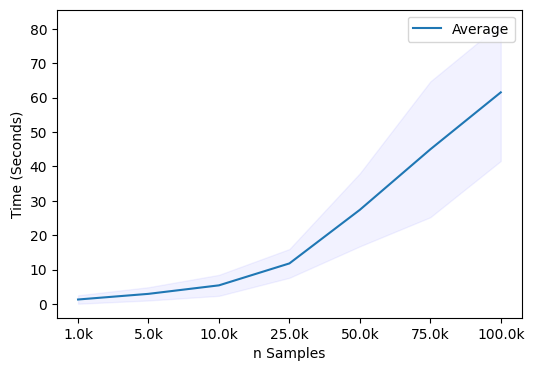

In [7]:

data = run_triage

plt.figure(figsize=(6, 4))

# Assuming each key represents a different trial and each value is a time at some sample number
x_values = list(next(iter(data.values())).keys())
xs = [f"{xval/1000}k" for xval in x_values]

# Calculate the mean and standard deviation at each x-value
ys = np.array([[val[0] for val in data[key].values()] for key in data])
mean_y = np.mean(ys, axis=0)
std_y = np.std(ys, axis=0)

# Plot the mean line
plt.plot(xs, mean_y, label="Average")

# Plot the shaded error bar
plt.fill_between(xs, mean_y - std_y, mean_y + std_y, color="b", alpha=0.05)

plt.xlabel("n Samples")
plt.ylabel("Time (Seconds)")
plt.legend()

plt.show()
